In [1]:
#import libraries
import os
import numpy as np 
import pandas as pd 
import warnings
import tqdm
# warnings.filterwarnings(action='ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
plt.rcParams.update({'figure.figsize': (20,6), 'figure.dpi':300,})
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras

In [2]:
# directory inclusion
dir_path = r"co2_emission\data\modified_19_20_21"
dir_list = os.listdir(dir_path)
dir_list

['Brazil.csv',
 'China.csv',
 'EU27 & UK.csv',
 'France.csv',
 'Germany.csv',
 'India.csv',
 'Italy.csv',
 'Japan.csv',
 'ROW.csv',
 'Russia.csv',
 'Spain.csv',
 'UK.csv',
 'US.csv',
 'WORLD.csv']

In [3]:
#import data of one country

path = os.path.join(dir_path+"\\",dir_list[0])
data = pd.read_csv(path,parse_dates=['Date'],dayfirst=True,)

data.index = data['Date']
#remove null columns
data.dropna(axis=1, how='any',inplace=True)

#display data
data

,Date,Power,Industry,Ground Transport,Residential,Domestic Aviation,International Aviation
Date,,,,,,,
2019-01-01,2019-01-01,0.108768,0.248140,0.201663,0.098452,0.023750,0.018398
2019-01-02,2019-01-02,0.123603,0.281984,0.341199,0.098452,0.032905,0.019761
2019-01-03,2019-01-03,0.121381,0.276915,0.418676,0.098452,0.033383,0.020915
2019-01-04,2019-01-04,0.111488,0.254346,0.443308,0.098452,0.032854,0.020518
2019-01-05,2019-01-05,0.118738,0.270886,0.371087,0.098452,0.031206,0.022138
...,...,...,...,...,...,...,...
2021-12-27,2021-12-27,0.219429,0.243593,0.442156,0.098452,0.037619,0.012932
2021-12-28,2021-12-28,0.231470,0.256959,0.443199,0.098452,0.034849,0.012084
2021-12-29,2021-12-29,0.225740,0.250599,0.438012,0.098452,0.034601,0.010744


In [4]:
data.dtypes
data.isna().sum()

Date                      datetime64[ns]
Power                            float64
Industry                         float64
Ground Transport                 float64
Residential                      float64
Domestic Aviation                float64
International Aviation           float64
dtype: object

Date                      0
Power                     0
Industry                  0
Ground Transport          0
Residential               0
Domestic Aviation         0
International Aviation    0
dtype: int64

In [5]:
#no of dates
Initial_date = data['Date'].iloc[0]
End_date = data['Date'].iloc[-1];

End_date
(End_date-Initial_date).days+1

Timestamp('2021-12-31 00:00:00')

1096

In [6]:
new_data = data[['Power']].copy()
new_data

,Power
Date,
2019-01-01,0.108768
2019-01-02,0.123603
2019-01-03,0.121381
2019-01-04,0.111488
2019-01-05,0.118738
...,...
2021-12-27,0.219429
2021-12-28,0.231470
2021-12-29,0.225740


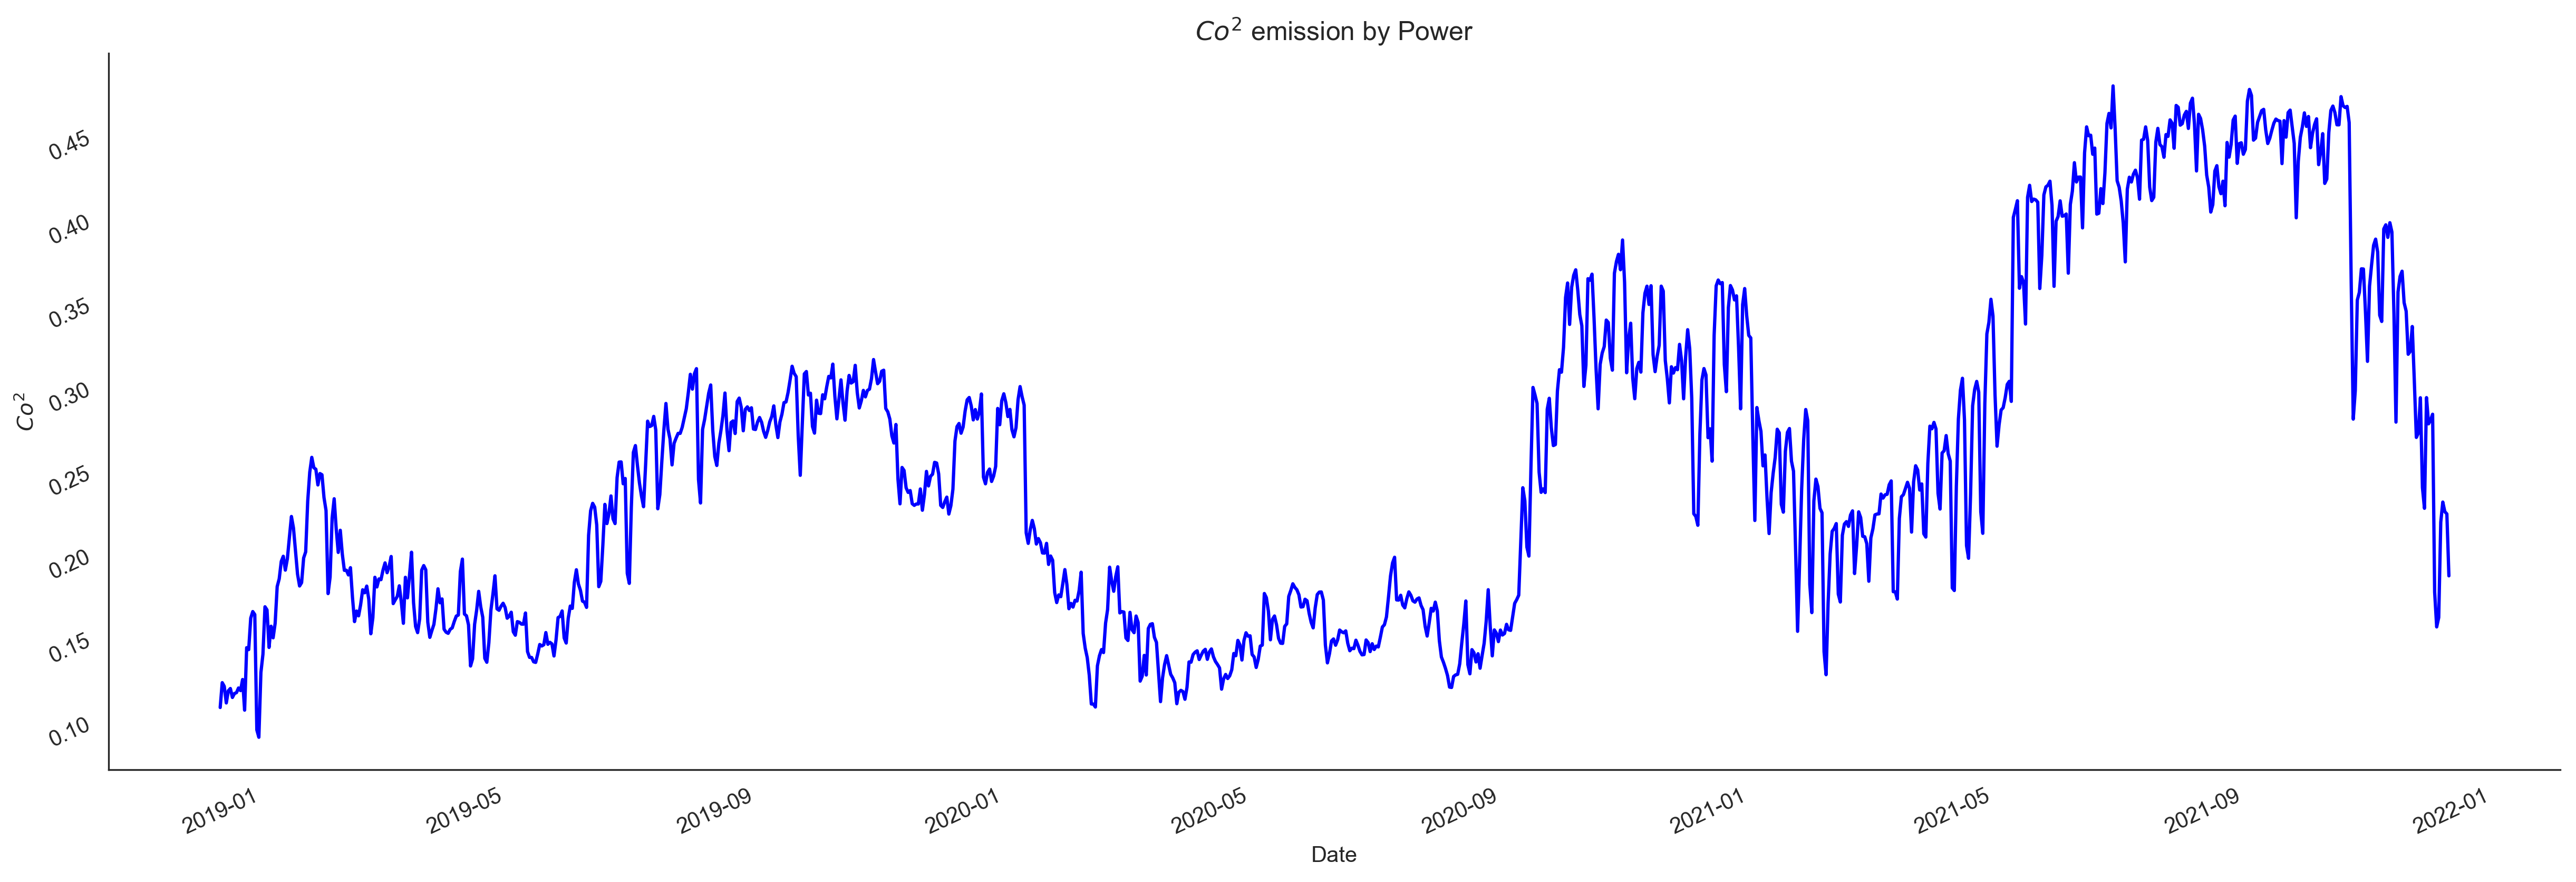

In [9]:
X = data['Date']; Y = data['Power']
#plot
sns.set_style("white")
ax = sns.lineplot(x="Date", y="Power", data=data, color='b');
ax.tick_params(rotation=25);
sns.despine()
plt.ylabel('$Co^2$');
plt.xlabel('Date');
plt.title('$Co^2$ emission by Power');
plt.show();

In [10]:
#normaliztion
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data['Power'].values.reshape(-1, 1))

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

876 220


In [12]:
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 10
x_train, y_train = create_dataset(train, look_back=look_back)
x_test, y_test = create_dataset(test, look_back=look_back)

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(865, 10)
(865,)
(209, 10)
(209,)


In [15]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(865, 1, 10)
(865,)
(209, 1, 10)
(209,)


In [21]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=30, batch_size=1, verbose=1)

Epoch 1/30
865/865 [==============================] - 8s 8ms/step - loss: 0.0080
Epoch 2/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0033
Epoch 3/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0027
Epoch 4/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 5/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0022
Epoch 6/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0021
Epoch 7/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0020
Epoch 8/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0021
Epoch 9/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0020
Epoch 10/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0020
Epoch 11/30
865/865 [==============================] - 9s 10ms/step - loss: 0.0020
Epoch 12/30
865/865 [==============================] - 7s 8ms/step - loss: 0.0019
Epoch 13/30
865/865 [===

In [19]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.04 RMSE


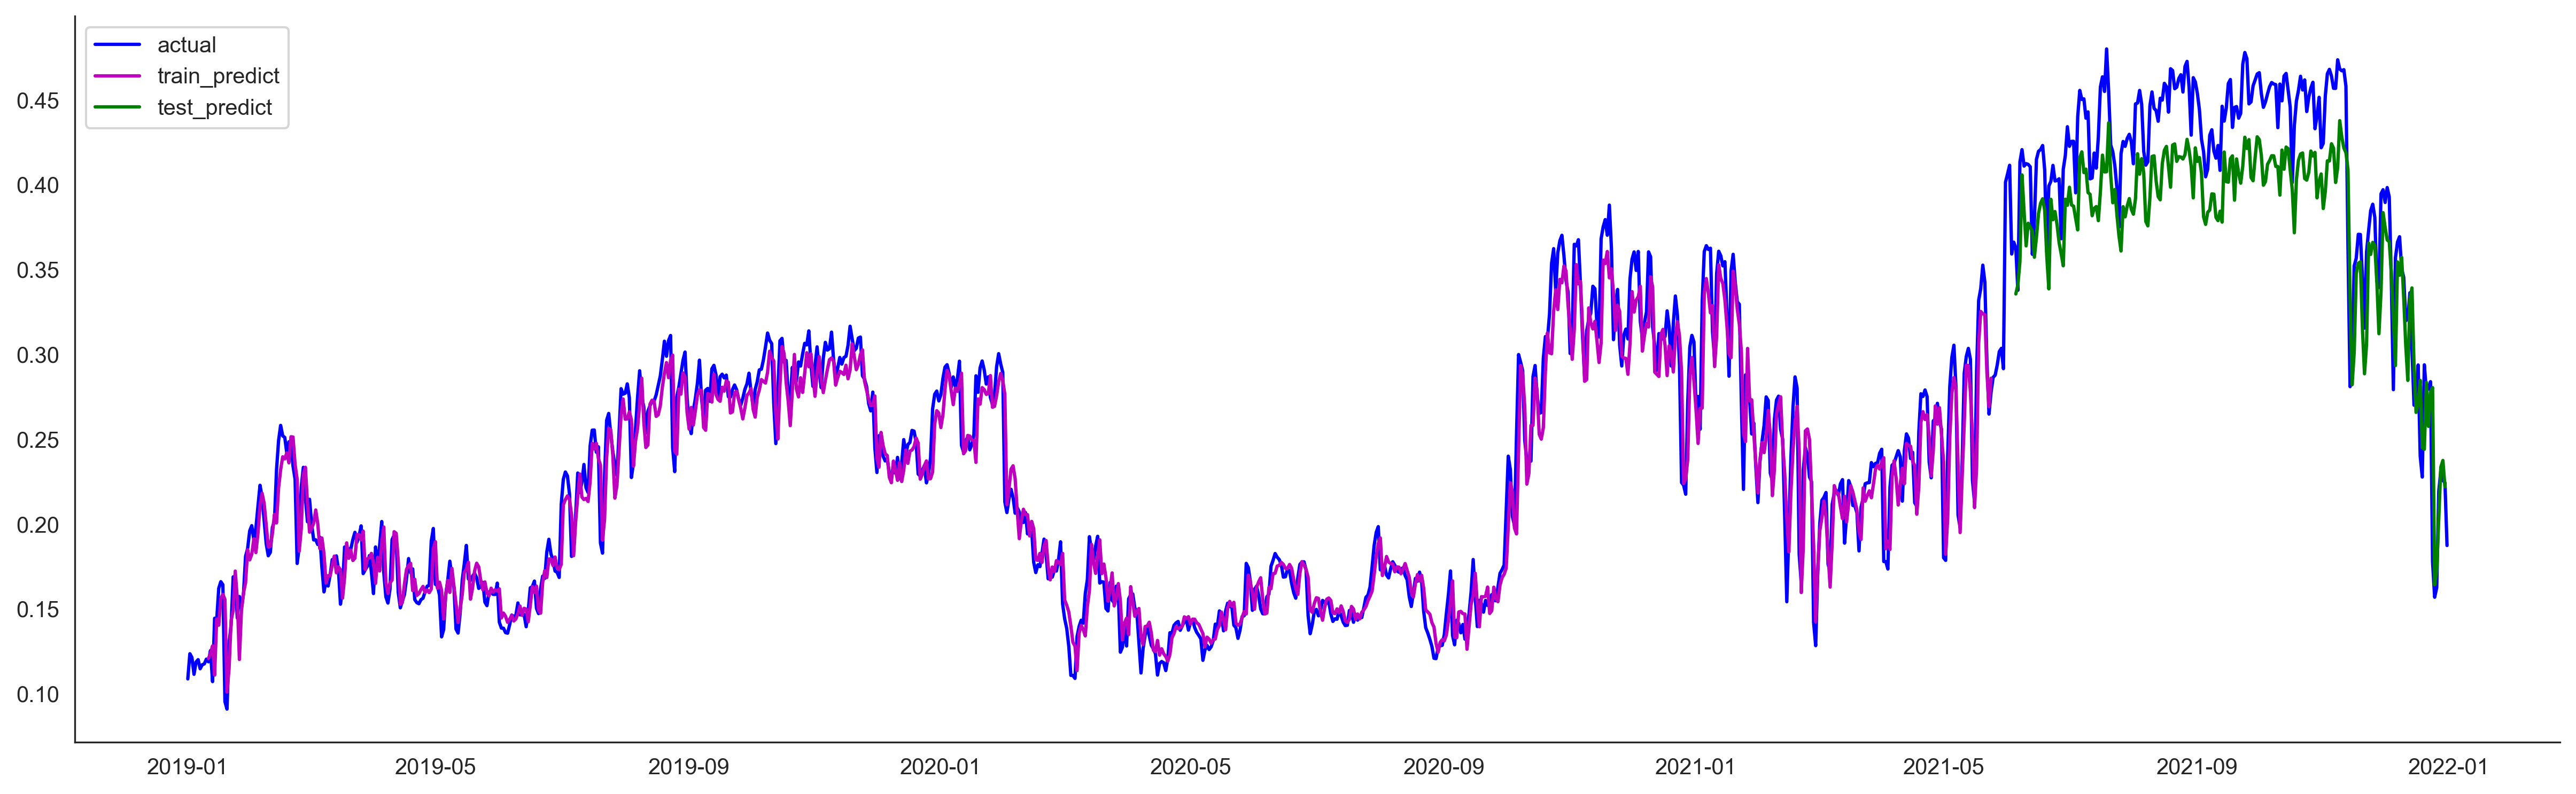

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(data.Date,min_max_scaler.inverse_transform(dataset),label="actual",color="b")
plt.plot(data.Date,trainPredictPlot,label="train_predict",color="m")
plt.plot(data.Date, testPredictPlot,label="test_predict",color="g")
plt.legend()
sns.despine()
plt.show();